In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
from stardist.models import StarDist2D

2023-10-17 17:06:00.907178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 17:06:00.907216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 17:06:00.908302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 17:06:01.022089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:06:02.384554: W tensorflow/compiler/

In [6]:
# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-10-17 17:06:04.212460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-17 17:06:04.212523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tibuch-X1
2023-10-17 17:06:04.212538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: tibuch-X1
2023-10-17 17:06:04.212758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2023-10-17 17:06:04.212802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2023-10-17 17:06:04.212811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.199.2


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [7]:
from tifffile import imread

In [8]:
w2 = imread('/tungstenfs/scratch/ggiorget/Jana/Microscopy/FISH/20230914_FISH/20230914_5B10_DAPI_GFP-561_MS2-640_1_w2Conf561.stk')
w3 = imread('/tungstenfs/scratch/ggiorget/Jana/Microscopy/FISH/20230914_FISH/20230914_5B10_DAPI_GFP-561_MS2-640_1_w3Conf405.stk')

In [9]:
from matplotlib import pyplot as plt

In [10]:
cells = (w1 + w2) // 2

In [13]:
import numpy as np

In [15]:
mi, ma = np.quantile(cells[np.argmax(np.mean(cells, axis=(1,2)))], [0.5, 1])

In [56]:
from skimage.filters import gaussian

In [57]:
cells_n = gaussian(np.clip((cells - mi) / (ma - mi), 0, 10), 2)

In [58]:
from csbdeep.utils import normalize

In [80]:
labelings = []
for plane in cells_n:
    labels, _ = model.predict_instances(plane, scale=0.33)
    labelings.append(labels)

In [81]:
from stardist.plot import render_label

In [82]:
import numpy as np

In [69]:
final_labeling = np.zeros_like(cells)

In [26]:
from tqdm import tqdm

In [ ]:
from 

In [85]:
final_labeling = np.zeros_like(cells)
final_labeling[0] = labelings[0]
for i, label in tqdm(enumerate(labelings[1:]), total=len(labelings)-1):
    for label_id in filter(None, np.unique(label)):
        candidate_labels, counts = np.unique(final_labeling[i, label == label_id], return_counts=True)        
        fg_labels = candidate_labels > 0
        candidate_labels = candidate_labels[fg_labels]
        counts = counts[fg_labels]
        merged_label_id = None
        if len(candidate_labels) == 0:
            # Background only
            merged_label_id = np.max(final_labeling) + 1
        elif len(candidate_labels) == 1:
            # Background and a single candidate
            union = np.zeros_like(label)
            union[label == label_id] = 1
            union[final_labeling[i] == candidate_labels[0]]
            if counts[0] / np.sum(union) > 0.5:
                merged_label_id = candidate_labels[0]
            else:
                merged_label_id = 0
        else:
            ious = []
            for count, c in zip(counts, candidate_labels):
                union = np.zeros_like(label)
                union[label == label_id] = 1
                union[final_labeling[i] == c] = 1
                ious.append(count / np.sum(union))

            max = np.argmax(ious)
            merged_label_id = candidate_labels[max]
            
        final_labeling[i+1, label == label_id] = merged_label_id

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]


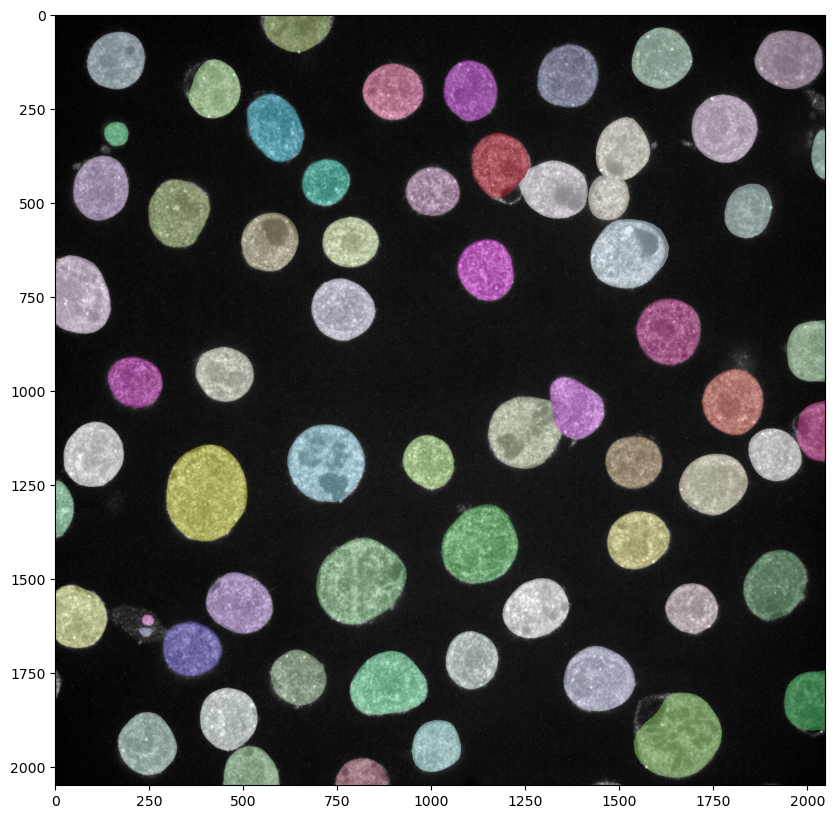

In [86]:
plt.figure(figsize=(10, 10))
i = 20
plt.imshow(render_label(final_labeling[i], img=cells[i]))

In [87]:
from tifffile import imwrite

In [88]:
imwrite('seg.tif',final_labeling)